In [1]:
library(Seurat)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject



# 数据导入以及质控

In [5]:
# Data setup

#This is an intergrated comparative analysis of two single cell datasets using Seurat development version 3.0.0.9200 [@satija2015spatial; @butler2018integrating; @stuart2019comprehensive; @hafemeister2019normalization].

### `r text_spec("Load data and create Seurat objects", color = "#4d648d", font_size=16)`

#First read in the scRNA-seq datasets and set up Seurat objects (this includes filtering cells/gens).

#```{r Seurat_setup_objects, message=FALSE,warning=FALSE, echo=FALSE, results="hide"}
## first read in the sample information sheet
sampleInfo<-read.table('anotation.txt', header=T, sep="\t")

## read data
scRNA.list<-list()
for (i in 1:nrow(sampleInfo)) {
  ## read in 10X data
  scData<-Read10X(data.dir = as.character(sampleInfo[i,3]))
  ## 去除核糖体基因
  scData=scData[!grepl(pattern = "^RP[SL]", rownames(scData)),]
  ## change cell names
  scData@Dimnames[2][[1]]<-paste0(as.character(sampleInfo[i,2]), "_", scData@Dimnames[2][[1]])
  ## create Seurat object
  scRNA <- CreateSeuratObject(scData, min.cells = 5, min.features = 200, project = as.character(sampleInfo[i,1]))
  scRNA[['sample']] <- as.character(sampleInfo[i,2]) ## or scRNA@meta.data$sample<-sample
  scRNA[['group']] <- as.character(sampleInfo[i,9])
  scRNA[['group2']] <- as.character(sampleInfo[i,10])
  ## mitochondrial genes
  ref<-as.character(sampleInfo[i,4])
  if (ref=="hg38") percent.mito <- percent.mito <- Matrix::colSums(GetAssayData(scRNA, slot = 'counts')[grep(pattern = "^MT-", rownames(scRNA), value = TRUE), ]) / Matrix::colSums(GetAssayData(scRNA, slot = 'counts'))

  if (ref=="mm10") percent.mito <- percent.mito <- Matrix::colSums(GetAssayData(scRNA, slot = 'counts')[grep(pattern = "^mt-", rownames(scRNA), value = TRUE), ]) / Matrix::colSums(GetAssayData(scRNA, slot = 'counts'))
  if (ref=="hg38") percent.ribo <- percent.ribo <- Matrix::colSums(GetAssayData(scRNA, slot = 'counts')[grep(pattern = "^RP[SL]", rownames(scRNA), value = TRUE), ]) / Matrix::colSums(GetAssayData(scRNA, slot = 'counts'))

  if (ref=="mm10") percent.ribo <- percent.ribo <- Matrix::colSums(GetAssayData(scRNA, slot = 'counts')[grep(pattern = "^Rp[sl]", rownames(scRNA), value = TRUE), ]) / Matrix::colSums(GetAssayData(scRNA, slot = 'counts'))
    ## add to meta data
  scRNA[['percent.mito']] <- percent.mito
  scRNA[['percent.ribo']] <- percent.ribo
  
  ## filter data
  scRNA <- subset(scRNA, subset = nFeature_RNA > sampleInfo[i,5] & nFeature_RNA < sampleInfo[i,6] & percent.mito < sampleInfo[i,7]&
                 percent.ribo < sampleInfo[i,8]
                 )
  ## assign data to data list
  #plot_filter(scRNA,paste('QC_',sampleInfo[i,2]))
  scRNA.list[[i]]<-scRNA
  rm(scRNA)
}
## add name to the data list
names(scRNA.list)<-as.character(sampleInfo[,2])
View(scRNA.list)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6

$`Skin-Y-18`
An object of class Seurat 
17136 features across 2886 samples within 1 assay 
Active assay: RNA (17136 features, 0 variable features)

$`Skin-Y-22`
An object of class Seurat 
15870 features across 2369 samples within 1 assay 
Active assay: RNA (15870 features, 0 variable features)

$`Skin-Y-23`
An object of class Seurat 
17566 features across 5136 samples within 1 assay 
Active assay: RNA (17566 features, 0 variable features)

$`Skin-M-44`
An object of class Seurat 
16751 features across 2819 samples within 1 assay 
Active assay: RNA (16751 features, 0 variable features)

$`Skin-M-47`
An object of class Seurat 
16960 features across 2693 samples within 1 assay 
Active assay: RNA (16960 features, 0 variable features)

$`Skin-M-48`
An object of class Seurat 
17667 features across 3340 samples within 1 assay 
Active assay: RNA (17667 features, 0 variable features)

$`Skin-O-70`
An object of class Seurat 
17857 features across 4380 samples within 1 assay 
Active assay: RNA (17

# CCA

In [6]:
## setup colors for plotting
colors<-c("#4d648d", "#0450fb", "#11aac4", "#42e8f3", "#AEC7E8", "#2CA02C", "#98DF8A", "#9eccaf", "#daf400", "#983b59", "#e81f3f", "#ff8b94", "#ffd3b6", "#f9ae34", "#ffdb00", "#723584", "#9264eb", "#ff00ff", "#E377C2", "#de94e4", "#F7B6D2", "#C5B0D5", "#8C564B", "#C49C94", "#BCBD22", "#DBDB8D", "#7F7F7F", "#C7C7C7", "#a7a7b7", "#9999FF",  "#CC6633", "#990066", "#003333", "#996666","#CF6633")



#After subsetting each dataset, each data will be log normalized and variable features will be identified with an improved methods based on a variance stabilizing transformation.

for (i in 1:length(scRNA.list)) {
    scRNA.list[[i]] <- NormalizeData(scRNA.list[[i]], verbose = FALSE)
    scRNA.list[[i]] <- FindVariableFeatures(scRNA.list[[i]], selection.method = "vst", nfeatures = 2500, verbose = FALSE)
}

# Data Integration

## Find integration anchors and integrate data

#```{r Seurat_FindIntegrationAnchors, message=FALSE,warning=FALSE, echo=FALSE, results='hide'}
scRNA.anchors <- FindIntegrationAnchors(scRNA.list, dims = 1:50)
scRNA.integrated <- IntegrateData(anchorset = scRNA.anchors, dims = 1:50)


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6566 anchors

Filtering anchors

	Retained 3893 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9891 anchors

Filtering anchors

	Retained 4874 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7768 anchors

Filtering anchors

	Retained 3471 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7895 anchors

Filtering anchors

	Retained 3931 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 6913 anchors

Filtering anchors

	Retained 3497 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9733 anchors

Filtering anchors

	Retained 5434 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7678 anchors


In [7]:
## switch to integrated assay, this is actually default
DefaultAssay(object = scRNA.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
scRNA.integrated <- ScaleData(object = scRNA.integrated, verbose = FALSE)
scRNA.integrated <- RunPCA(object = scRNA.integrated, npcs = 50, verbose = FALSE)


# 常规操作-UMAP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 34550
Number of edges: 1516163

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8400
Number of communities: 44
Elapsed time: 7 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
05:22:49 UMAP embedding parameters a = 0.9922 b = 1.112

05:22:49 Read 34550 rows and found 32 numeric columns

05:22:49 Using Annoy for neighbor search, n_neighbors = 30

05:22:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:22:53 Writing NN index file to temp file /tmp/RtmpnQQpNr/file8de745c77ea

05:22:53 Searching Annoy index using 1 thread, search_k = 3000

05:23:03 Annoy recall = 100%

05:23:05 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

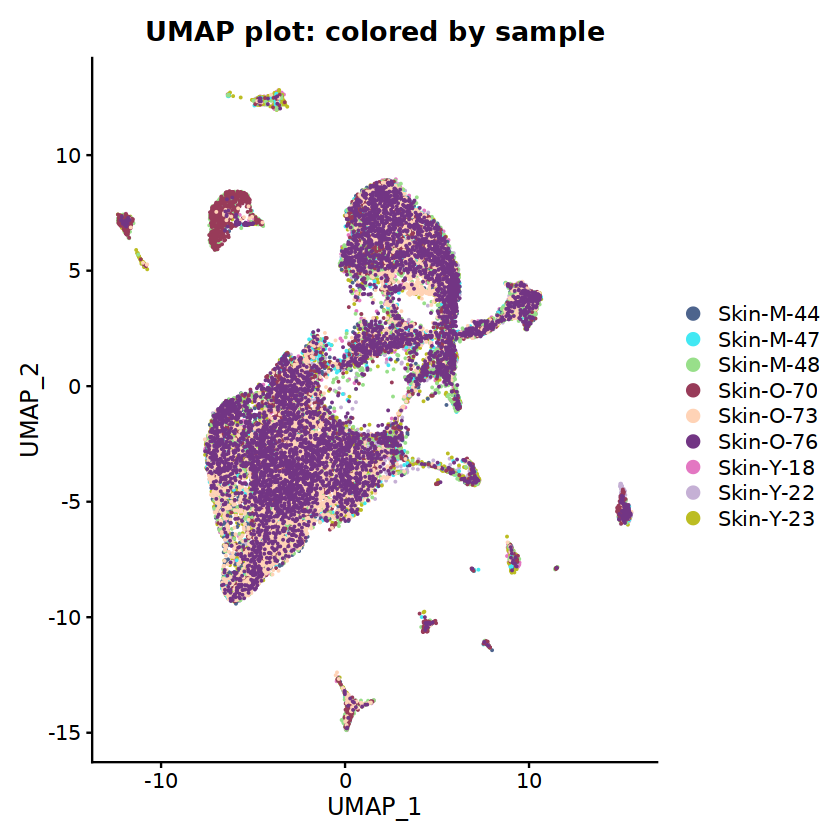

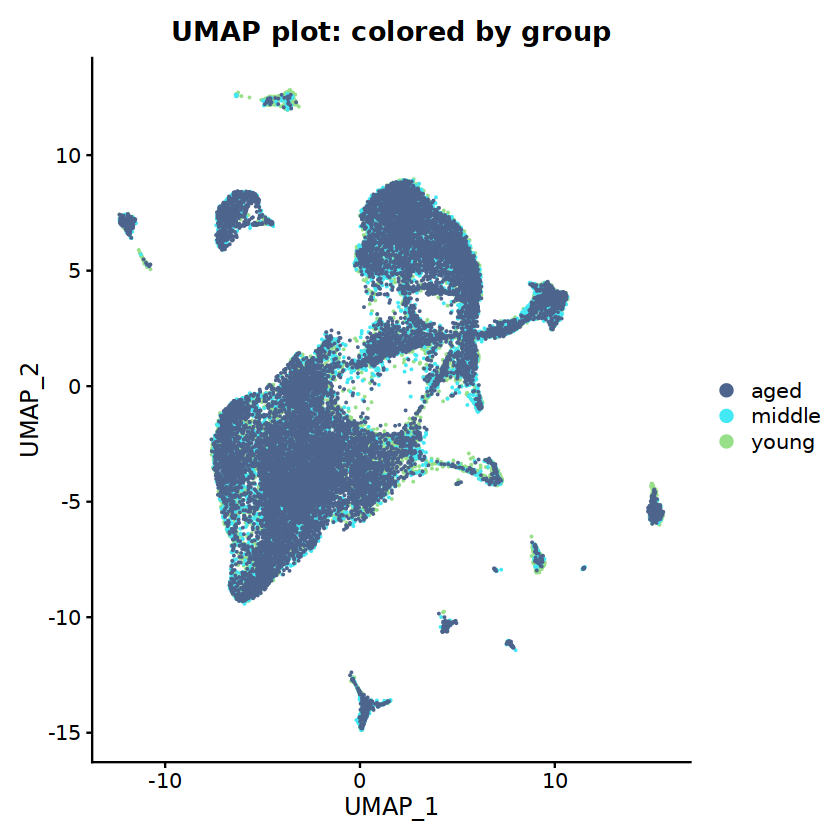

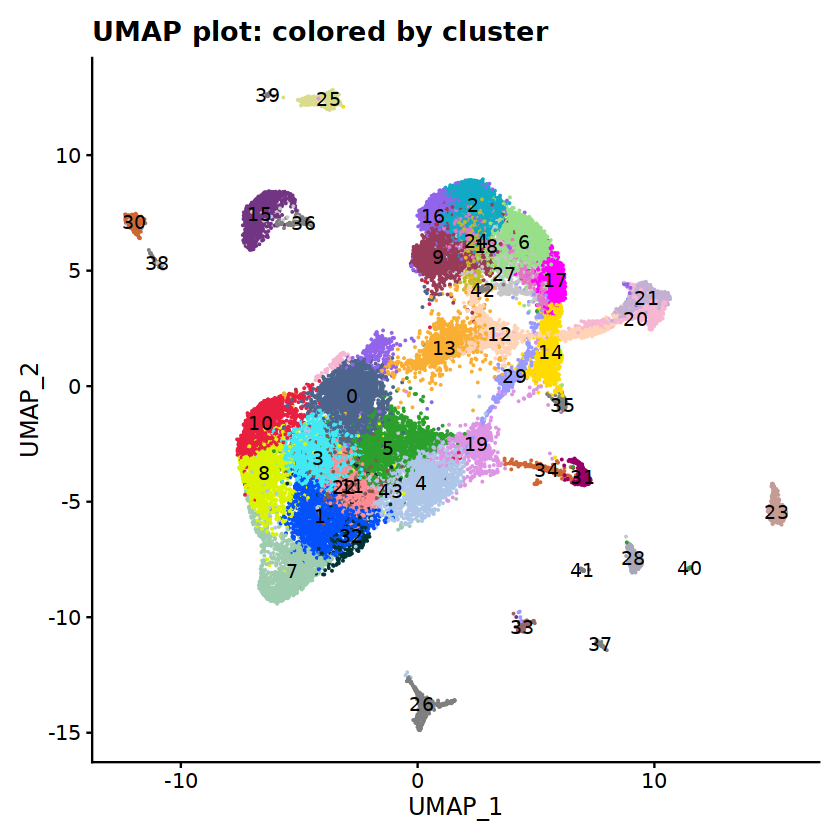

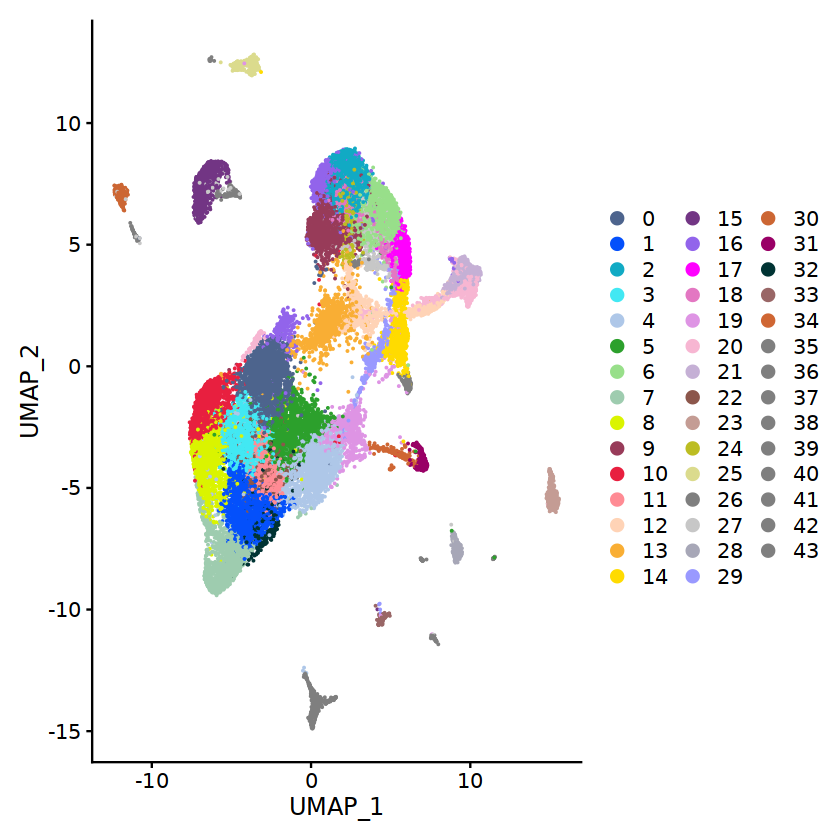

In [8]:
## switch to integrated assay, this is actually default
#DefaultAssay(object = scRNA.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
#scRNA.integrated <- ScaleData(object = scRNA.integrated, verbose = FALSE)
#scRNA.integrated <- RunPCA(object = scRNA.integrated, npcs = 50, verbose = FALSE)

## Graph-based clustering

#Clusters were identified with the Seurat functions "FindNeighbors" and FindClusters" using a resolution of 1 and 40 PCs.

#```{r Seurat_cell_clustering, message=FALSE,warning=FALSE, echo=FALSE, results='hide'}
scRNA.integrated <- FindNeighbors(scRNA.integrated, dims = 1:32, verbose=FALSE)
scRNA.integrated <- FindClusters(scRNA.integrated, resolution = 1.9)  ##############################?????????????????

scRNA.integrated <- RunUMAP(object = scRNA.integrated, reduction = "pca", dims = 1:32)
#scRNA.integrated <- RunTSNE(object = scRNA.integrated, reduction = "pca", dims = 1:40)

#DimPlot(scRNA.integrated, reduction = "tsne", group.by = "sample", cols=colors[seq(1, by=3, length(colors))][1:nrow(sampleInfo)]) + ggtitle("TSNE plot: colored by sample")
#DimPlot(scRNA.integrated, reduction = "tsne", label = TRUE, repel = TRUE, cols=colors[1:length(unique(scRNA.integrated@active.ident))]) + NoLegend() + ggtitle("TSNE plot: colored by cluster")
#DimPlot(scRNA.integrated, reduction = "tsne", label = FALSE, cols=colors[1:length(unique(scRNA.integrated@active.ident))])


###  `r text_spec("UMAP plots", color = "#4d648d", font_size=16)`

#### UMAP: Uniform Manifold Approximation and Projection

#```{r Seurat_UMAP, message=FALSE, warning=FALSE, echo=FALSE, results='hide'}
DimPlot(scRNA.integrated, reduction = "umap", group.by = "sample", cols=colors[seq(1, by=3, length(colors))][1:nrow(sampleInfo)]) + ggtitle("UMAP plot: colored by sample")
DimPlot(scRNA.integrated, reduction = "umap", group.by = "group", cols=colors[seq(1, by=3, length(colors))][1:nrow(sampleInfo)]) + ggtitle("UMAP plot: colored by group")
DimPlot(scRNA.integrated, reduction = "umap", label = TRUE, repel = FALSE, cols=colors[1:length(unique(scRNA.integrated@active.ident))]) + NoLegend() + ggtitle("UMAP plot: colored by cluster")
DimPlot(scRNA.integrated, reduction = "umap", label = FALSE, cols=colors[1:length(unique(scRNA.integrated@active.ident))])
#```



# 保存

In [15]:
saveRDS(scRNA.integrated, file = "all_IntegrativeAnalysis.rds")
## save cluster-specific marker genes
#saveRDS(ct.markers.pos_top, file = "all_IntegrativeAnalysis_clusterMarkerGenes.rds")